In [3]:
import numpy as np
import pandas as pd
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import string
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("news_summary.csv", encoding='latin1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [5]:
# Shape of the dataset
print ("The shape of the dataset : ", df.shape)

The shape of the dataset :  (4514, 6)


[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Author'),
 Text(0.5, 1.0, 'Distribution of Publication according')]

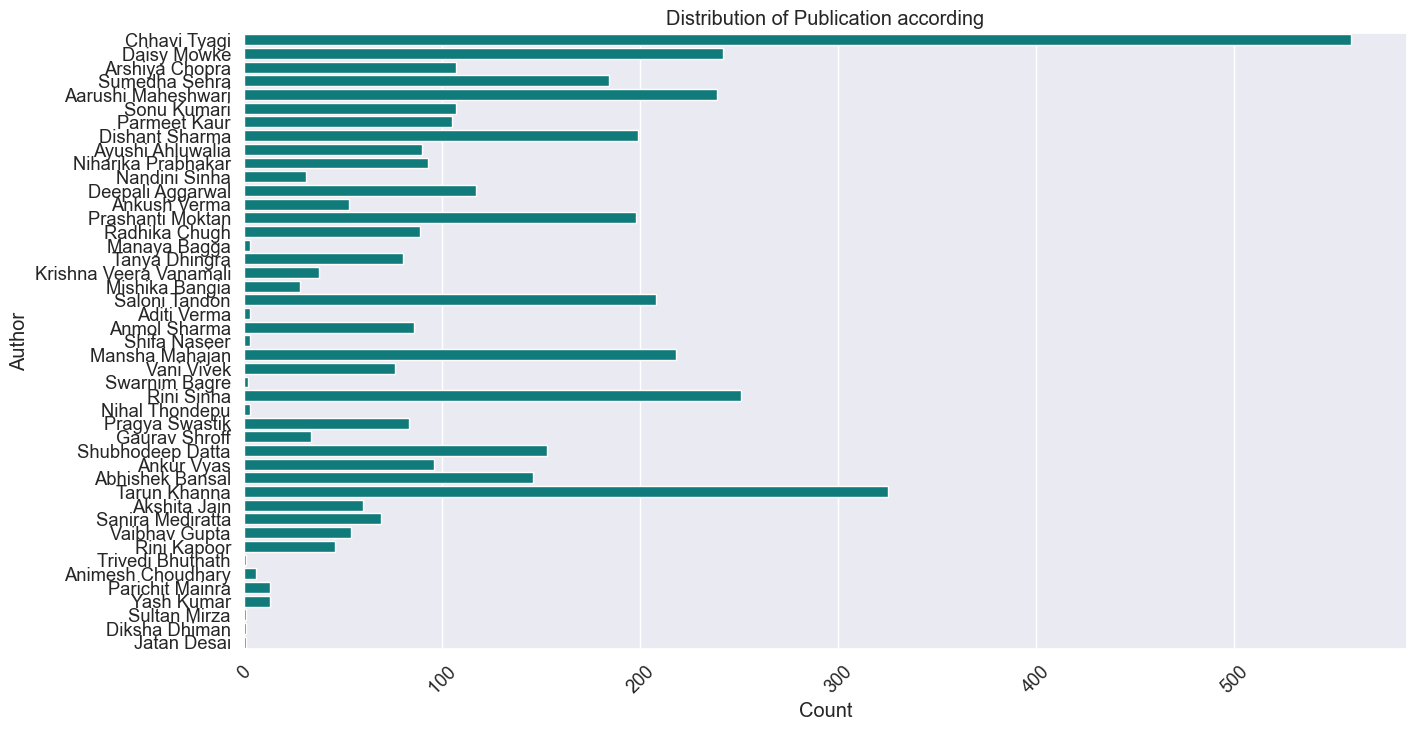

In [6]:
# Countplot shows the distribution of Publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_year = sns.countplot(df['author'], color = 'darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel = "Count", ylabel = "Author", title = "Distribution of Publication according")

In [7]:
df['year'] = pd.to_datetime(df['date'], format='%d %b %Y,%A').dt.year

In [8]:
df['year'].value_counts()

year
2017    4145
2016     369
Name: count, dtype: int64

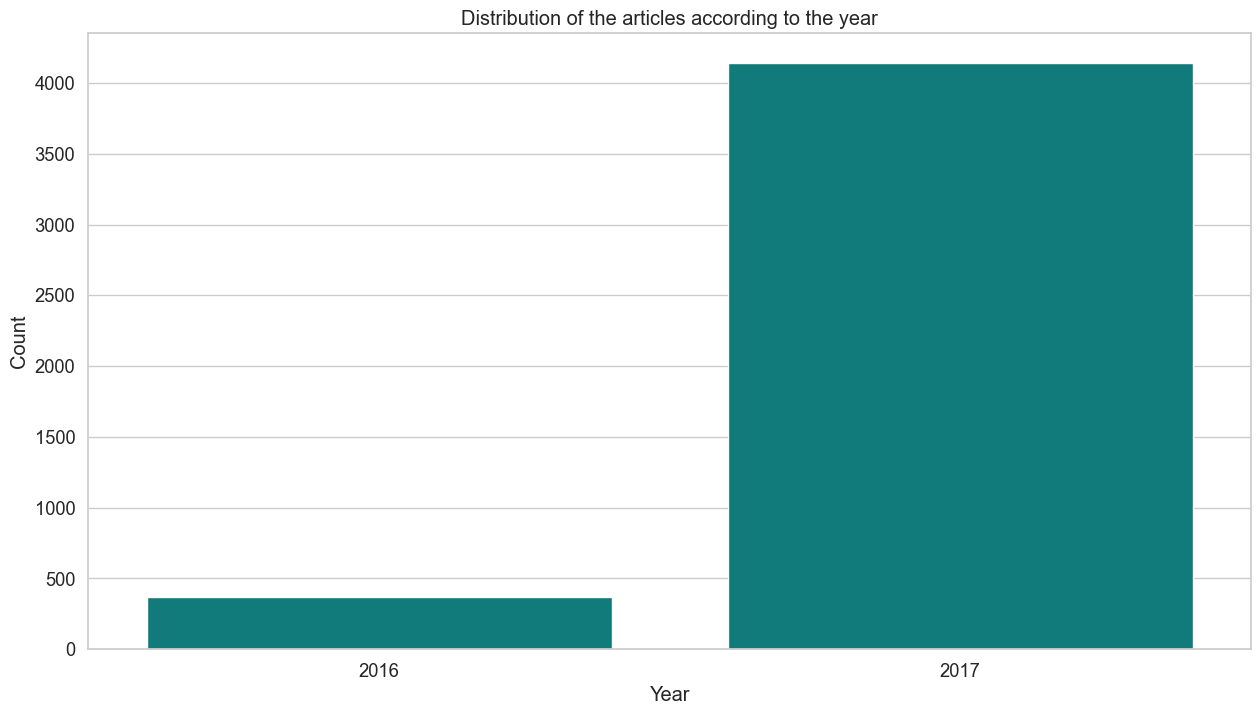

In [9]:
# Set the plot size and theme
plt.rcParams['figure.figsize'] = [15, 8]
sns.set_theme(font_scale=1.2, style='whitegrid')

# Create the countplot
sns_year = sns.countplot(x='year', data=df, color='darkcyan')
sns_year.set(xlabel="Year", ylabel="Count", title="Distribution of the articles according to the year")

# Display the plot
plt.show()

In [10]:
df['author'].value_counts()

author
Chhavi Tyagi              559
Tarun Khanna              325
Rini Sinha                251
Daisy Mowke               242
Aarushi Maheshwari        239
Mansha Mahajan            218
Saloni Tandon             208
Dishant Sharma            199
Prashanti Moktan          198
Sumedha Sehra             184
Shubhodeep Datta          153
Abhishek Bansal           146
Deepali Aggarwal          117
Arshiya Chopra            107
Sonu Kumari               107
Parmeet Kaur              105
Ankur Vyas                 96
Niharika Prabhakar         93
Ayushi Ahluwalia           90
Radhika Chugh              89
Anmol Sharma               86
Pragya Swastik             83
Tanya Dhingra              80
Vani Vivek                 76
Sanira Mediratta           69
Akshita Jain               60
Vaibhav Gupta              54
Ankush Verma               53
Rini Kapoor                46
Krishna Veera Vanamali     38
Gaurav Shroff              34
Nandini Sinha              31
Mishika Bangia             28
Par

Making the article Summarizer


In [11]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [12]:
# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [13]:
# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [14]:
# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

In [15]:
# Function to normalize the word frequency which is used in the function word_frequency
def normalize(li_word):
    global normalized_freq
    normalized_freq = []
    for dictionary in li_word:
        max_frequency = max(dictionary.values())
        for word in dictionary.keys():
            dictionary[word] = dictionary[word]/max_frequency
        normalized_freq.append(dictionary)
    return normalized_freq

In [16]:
# Function to calculate the word frequency
def word_frequency(article_word):
    word_frequency = {}
    li_word = []
    for sentence in article_word:
        for word in word_tokenize(sentence):
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
        li_word.append(word_frequency)
        word_frequency = {}
    normalize(li_word)
    return normalized_freq


In [17]:
# Function to Score the sentence which is called in the function sent_token
def sentence_score(li):
    global sentence_score_list
    sentence_score = {}
    sentence_score_list = []
    for list_, dictionary in zip(li, normalized_freq):
        for sent in list_:
            for word in word_tokenize(sent):
                if word in dictionary.keys():
                    if sent not in sentence_score.keys():
                        sentence_score[sent] = dictionary[word]
                    else:
                        sentence_score[sent] += dictionary[word]
        sentence_score_list.append(sentence_score)
        sentence_score = {}
    return sentence_score_list

In [18]:
# Function to tokenize the sentence
def sent_token(article_sent):
    sentence_list = []
    sent_token = []
    for sent in article_sent:
        token = sent_tokenize(sent)
        for sentence in token:
            token_2 = ''.join(word for word in sentence if word not in punctuation)
            token_2 = re.sub(' +', ' ',token_2)
            sent_token.append(token_2)
        sentence_list.append(sent_token)
        sent_token = []
    sentence_score(sentence_list)
    return sentence_score_list

In [19]:
# Function which generates the summary of the articles (This uses the 20% of the sentences with the highest score)
def summary(sentence_score_OwO):
    summary_list = []
    for summ in sentence_score_OwO:
        select_length = int(len(summ)*0.25)
        summary_ = nlargest(select_length, summ, key = summ.get)
        summary_list.append(".".join(summary_))
    return summary_list

In [20]:
# Functions to change the article string (if passed) to change it to generate a pandas series
def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

In [21]:
# Function which is to be called to generate the summary which in further calls other functions alltogether
def article_summarize(artefact):
    
    if type(artefact) != pd.Series:
        artefact = make_series(artefact)
    
    df = preprocessing(artefact)
    
    word_normalization = word_frequency(df)
    
    sentence_score_OwO = sent_token(article_sent)
    
    summarized_article = summary(sentence_score_OwO)
    
    return summarized_article


In [22]:
# Generating the Word Cloud of the article using the preprocessing and make_series function mentioned below
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off')
    plt.show()
# Generating the summaries for the first 100 articles
summaries = article_summarize(df['ctext'][0:100])

In [23]:
print ("The Actual length of the article is : ", len(df['ctext'][0]))
df['ctext'][0]

The Actual length of the article is :  2313


'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [24]:
print ("The length of the summarized article is : ", len(summaries[0]))
summaries[0]

The length of the summarized article is :  1173


'she refused to be identifiedthe notice was issued on daman and diu administrator and former gujarat home minister praful kodabhai patels direction sources saidrakshabandhan a celebration of the bond between brothers and sisters is one of several hindu festivities and rituals that are no longer confined of private family affairs but have become tools to push politic al ideologiesin 2014 the year bjp stormed to power at the centre rashtriya swayamsevak sangh rss chief mohan bhagwat said the festival had national significance.the daman and diu administration on wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social mediathe union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace.it has been decided to celebrate the festival of rakshabandhan on august 7 in this c

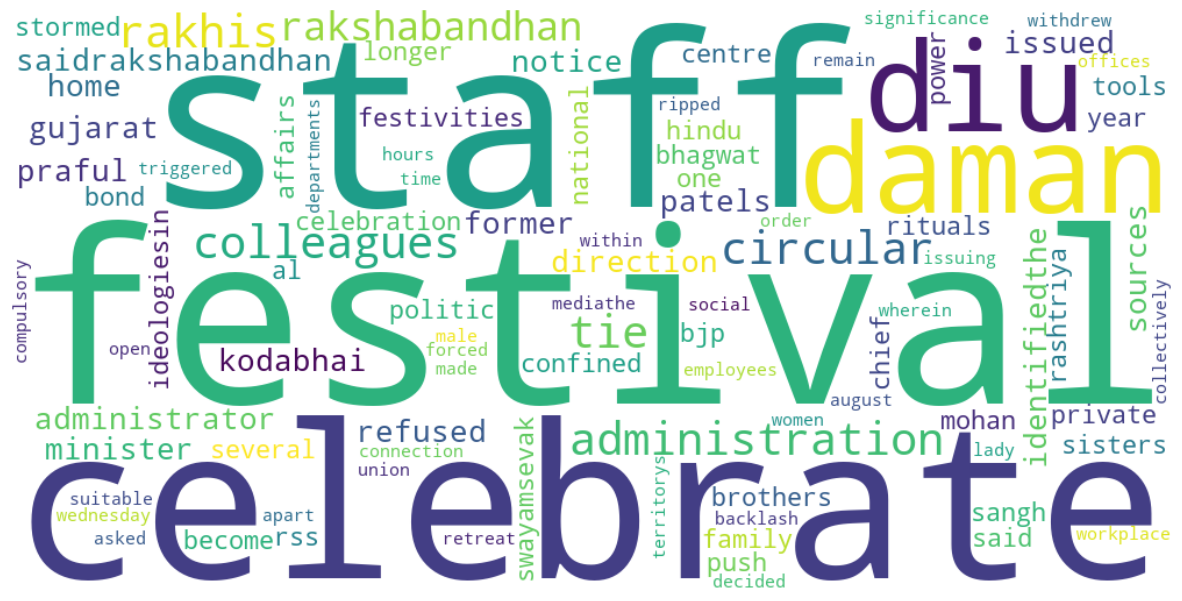

In [25]:
word_cloud(summaries[0])

In [26]:
summary = article_summarize("Snakes are elongated, limbless reptiles of the suborder Serpentes (/sɜːrˈpɛntiːz/).[2] Like all other squamates, snakes are ectothermic, amniote vertebrates covered in overlapping scales. Many species of snakes have skulls with several more joints than their lizard ancestors, enabling them to swallow prey much larger than their heads (cranial kinesis). To accommodate their narrow bodies, snakes' paired organs (such as kidneys) appear one in front of the other instead of side by side, and most have only one functional lung. Some species retain a pelvic girdle with a pair of vestigial claws on either side of the cloaca. Lizards have independently evolved elongate bodies without limbs or with greatly reduced limbs at least twenty-five times via convergent evolution, leading to many lineages of legless lizards.[3] These resemble snakes, but several common groups of legless lizards have eyelids and external ears, which snakes lack, although this rule is not universal (see Amphisbaenia, Dibamidae, and Pygopodidae). Living snakes are found on every continent except Antarctica, and on most smaller land masses; exceptions include some large islands, such as Ireland, Iceland, Greenland, and the islands of New Zealand, as well as many small islands of the Atlantic and central Pacific oceans.[4] Additionally, sea snakes are widespread throughout the Indian and Pacific oceans. Around thirty families are currently recognized, comprising about 520 genera and about 3,900 species.[5] They range in size from the tiny, 10.4 cm-long (4.1 in) Barbados threadsnake[6] to the reticulated python of 6.95 meters (22.8 ft) in length.[7] The fossil species Titanoboa cerrejonensis was 12.8 meters (42 ft) long.[8] Snakes are thought to have evolved from either burrowing or aquatic lizards, perhaps during the Jurassic period, with the earliest known fossils dating to between 143 and 167 Ma ago.[9][10] The diversity of modern snakes appeared during the Paleocene epoch (c. 66 to 56 Ma ago, after the Cretaceous–Paleogene extinction event). The oldest preserved descriptions of snakes can be found in the Brooklyn Papyrus. Most species of snake are nonvenomous and those that have venom use it primarily to kill and subdue prey rather than for self-defense. Some possess venom that is potent enough to cause painful injury or death to humans. Nonvenomous snakes either swallow prey alive or kill by constriction.")

In [27]:
print(summary)

['living snakes are found on every continent except antarctica and on most smaller land masses exceptions include some large islands such as ireland iceland greenland and the islands of new zealand as well as many small islands of the atlantic and central pacific oceans.3 these resemble snakes but several common groups of legless lizards have eyelids and external ears which snakes lack although this rule is not universal see amphisbaenia dibamidae and pygopodidae.many species of snakes have skulls with several more joints than their lizard ancestors enabling them to swallow prey much larger than their heads cranial kinesis.to accommodate their narrow bodies snakes paired organs such as kidneys appear one in front of the other instead of side by side and most have only one functional lung']
